<a href="https://colab.research.google.com/github/advait416/Grapesnet/blob/main/unet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/advait416/Grapesnet.git

Cloning into 'Grapesnet'...
remote: Enumerating objects: 11742, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 11742 (delta 1), reused 287 (delta 1), pack-reused 11455
Receiving objects: 100% (11742/11742), 3.31 GiB | 35.71 MiB/s, done.
Resolving deltas: 100% (761/761), done.
Updating files: 100% (12117/12117), done.


In [2]:
pip install tensorflow==v2.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0

In [3]:
pip install keras

In [4]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from PIL import Image
from keras.optimizers import Adam

In [5]:
train_data_dir_images = '/content/Grapesnet/Test/Test_set/Images'
train_data_dir_masks = '/content/Grapesnet/Test/Train_set/Masks'
test_data_dir_images='/content/Grapesnet/Test/Test_set/Images'
test_data_dir_masks='/content/Grapesnet/Test/Test_set/Masks'


In [24]:
image_height, image_width = 256,256
num_classes = 2

In [25]:
def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)  # Change the number of channels to 3

    outputs = layers.Conv2D(3, 1, activation='softmax')(conv9)  # Change the number of channels to 3

    model = keras.Model(inputs, outputs)
    return model


In [26]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

def load_data(data_dir_images, data_dir_masks, image_height, image_width):
    images = []
    masks = []

    # Ensure that the data directories exist
    if not os.path.exists(data_dir_images) or not os.path.exists(data_dir_masks):
        raise ValueError("Data directories do not exist.")

    # List files in the image and mask directories
    image_file_list = os.listdir(data_dir_images)
    mask_file_list = os.listdir(data_dir_masks)

    # Sort the file lists to ensure corresponding images and masks match
    image_file_list.sort()
    mask_file_list.sort()

    # Check if the number of images and masks match
    if len(image_file_list) != len(mask_file_list):
        raise ValueError("Number of images and masks do not match.")

    for image_filename, mask_filename in zip(image_file_list, mask_file_list):
        if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            img = load_img(
                os.path.join(data_dir_images, image_filename),
                grayscale=False,  # Set to True if images are grayscale
                color_mode='rgb',  # Set to 'grayscale' for grayscale images
                target_size=(image_height, image_width)
            )
            img = img_to_array(img)
            images.append(img)

            # Load mask
            mask = load_img(
                os.path.join(data_dir_masks, mask_filename),
                target_size=(image_height, image_width)
            )
            mask = img_to_array(mask)
            masks.append(mask)

    return np.array(images), np.array(masks)







In [27]:
train_images,train_masks= load_data(train_data_dir_images,train_data_dir_masks,image_height, image_width)
test_images, test_masks = load_data(test_data_dir_images,test_data_dir_masks,image_height, image_width)
print(train_images.shape)
print(train_masks.shape)
test_images,test_masks=load_data(test_data_dir_images,test_data_dir_masks,image_height, image_width)
print(test_images.shape)
print(test_masks.shape)


(140, 256, 256, 3)
(140, 256, 256, 3)
(140, 256, 256, 3)
(140, 256, 256, 3)


In [23]:
#import cv2
#
#def resize_images(images):
#  resized_images = []
#  for image in images:
#    # Read the image from the file.
#    image_mat = cv2.imread(image)
#
#    # Check if the image was read successfully.
#    if image_mat is None:
#      # Skip the image if it could not be read.
#      continue
#
#    # Resize the image to the desired size.
#    resized_image = cv2.resize(image_mat, (500, 500))
#
#    # Convert the cv2.Mat object back to a NumPy array.
#    resized_image = resized_image.astype(np.uint8)
#
#    # Add the resized image to the list.
#    resized_images.append(resized_image)
#
#  return resized_images
#
#def resize_masks(masks):
#  resized_masks = []
#  for mask in masks:
#    # Read the image from the file.
#    mask_mat = cv2.imread(mask)
#
#    # Check if the image was read successfully.
#    if mask_mat is None:
#      # Skip the image if it could not be read.
#      continue
#
#    # Resize the image to the desired size.
#    resized_mask = cv2.resize(mask_mat, (500, 500))
#
#    # Convert the cv2.Mat object back to a NumPy array.
#    resized_mask = resized_mask.astype(np.uint8)
#
#    # Add the resized mask to the list.
#    resized_masks.append(resized_mask)
#
#  return resized_masks
#
## Resize the training images.
#train_images = resize_images(train_images)
#
## Resize the test images.
#train_masks = resize_masks(train_masks)


TypeError: ignored

In [51]:
import numpy as np
import cv2  # OpenCV for image processing (you may need to install it)

def preprocess_images(images):
    # Normalize pixel values to the range [0, 1]
    images = images.astype(np.float32)/ 255.0
    print(images.shape)
    return images

def preprocess_masks(masks):
    # Ensure masks have a binary format (0s and 1s)
    train_masks_binary = (train_masks > 0).astype(np.uint8)
    print(train_masks_binary.shape)
    return train_masks_binary

# Example usage:
# Assuming you have loaded train_images and train_masks
train_images, train_masks = load_data(train_data_dir_images, train_data_dir_masks, image_height, image_width)

# Preprocess and normalize images
train_images = preprocess_images(train_images)

# Preprocess masks (binary format)
train_masks = preprocess_masks(train_masks)

# Print the shapes of the preprocessed data
print("Preprocessed Train Images Shape:", train_images.shape)
print("Preprocessed Train Masks Shape:", train_masks.shape)


(140, 256, 256, 3)
(140, 256, 256, 3)
Preprocessed Train Images Shape: (140, 256, 256, 3)
Preprocessed Train Masks Shape: (140, 256, 256, 3)


In [52]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_images, test_images, train_masks, test_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# Normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# If you have a specific deep learning framework (e.g., TensorFlow or PyTorch),
# you may need to further preprocess the data, such as converting it to tensors.

# Example of converting data to tensors using TensorFlow:
import tensorflow as tf
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
train_masks = tf.convert_to_tensor(train_masks, dtype=tf.float32)
test_masks = tf.convert_to_tensor(test_masks, dtype=tf.float32)

# Print the shapes of the data arrays
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Test Masks Shape:", test_masks.shape)


Train Images Shape: (112, 256, 256, 3)
Test Images Shape: (28, 256, 256, 3)
Train Masks Shape: (112, 256, 256, 3)
Test Masks Shape: (28, 256, 256, 3)


In [53]:
model = unet_model((image_height, image_width, 3))  # Adjust input shape according to your data
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
# Train the model
epochs = 40 # You can adjust the number of epochs
batch_size = 20

In [76]:
history = model.fit (
    train_images, train_masks,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # You can use a validation split if needed
)

Epoch 1/40
5/5 [==============================] - 6s 1s/step - loss: 0.3381 - accuracy: 0.3556 - val_loss: 0.3631 - val_accuracy: 0.2468
Epoch 2/40
5/5 [==============================] - 6s 1s/step - loss: 0.3379 - accuracy: 0.2712 - val_loss: 0.3638 - val_accuracy: 0.2126
Epoch 3/40
5/5 [==============================] - 6s 1s/step - loss: 0.3372 - accuracy: 0.3120 - val_loss: 0.3630 - val_accuracy: 0.2678
Epoch 4/40
5/5 [==============================] - 6s 1s/step - loss: 0.3370 - accuracy: 0.3107 - val_loss: 0.3636 - val_accuracy: 0.2040
Epoch 5/40
5/5 [==============================] - 6s 1s/step - loss: 0.3382 - accuracy: 0.2626 - val_loss: 0.3640 - val_accuracy: 0.3000
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 0.3381 - accuracy: 0.3518 - val_loss: 0.3632 - val_accuracy: 0.2460
Epoch 7/40
5/5 [==============================] - 6s 1s/step - loss: 0.3373 - accuracy: 0.2560 - val_loss: 0.3631 - val_accuracy: 0.1693
Epoch 8/40
5/5 [=========================

In [35]:
#import tensorflow as tf
#import numpy as np
#
## Load the test images
#test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
#
## Make predictions on the test images
#predictions = model.predict(test_images)
#
## Convert the predictions to images
#predicted_images = predictions * 255.0
#predicted_images = np.uint8(predicted_images)
#
## Save the predicted images to a directory
#predicted_images_dir = 'predicted_images'
#if not os.path.exists(predicted_images_dir):
#  os.mkdir(predicted_images_dir)
#
#for i in range(len(test_images)):
#  predicted_image = predicted_images[i]
#  image_filename = os.path.join(predicted_images_dir, f'predicted_image_{i}.png')
#  cv2.imwrite(image_filename, predicted_image)


1/1 [==============================] - 0s 35ms/step


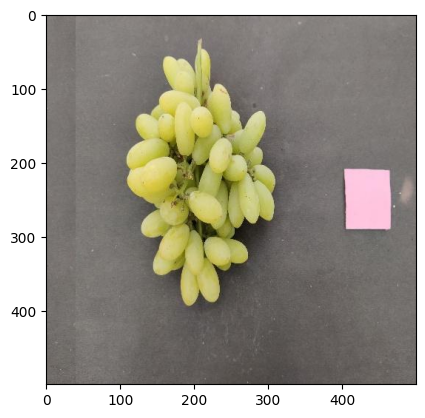

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/Grapesnet/Test/Test_set/Images/Image(2703).jpg')
imgplot = plt.imshow(img)
plt.show()